In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN.ipynb"
#!python setup.py develop 
# !pip install wandb
# !pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob, math, os, shutil, tempfile, time, monai, torch, random

import wandb as wb
from enum import Enum
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from monai.networks.utils import eval_mode
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    ImageDataset,
    Dataset,
    decollate_batch,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from vit_pytorch.efficient import ViT
from linformer import Linformer
from sklearn.model_selection import train_test_split
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from monai.utils import set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

MONAI version: 0.9.0rc2+9.gf89b3afe.dirty
Numpy version: 1.20.1
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f89b3afe1645210a6aa519123f239d9b000e9797
MONAI __file__: /home/alexanderalbizu/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 9.1.1
Tensorboard version: 1.15.0+nv
gdown version: 4.4.0
TorchVision version: 0.9.0a0
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


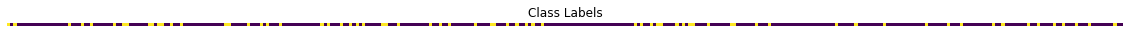

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
train_batch = 30; val_batch=7;
im_size = (96,96,96)
pat_size = (24,24,24)
gamma = 0.7
seed = 42

# Two binary labels for Healthy vs pre-MCI
lab = np.array([sdata[:,1]]);

class Diagnosis(Enum):
    normal = 0
    preMCI = 1

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

sub-100161 (1/349) T1 Data
(181, 217, 181)


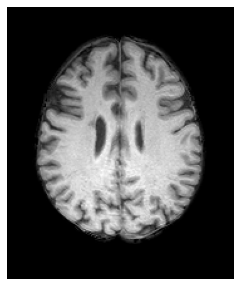

In [4]:
images = [os.path.join(rootDir,'anat',''.join(['wc0csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])];

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)    

train_list, valid_list = train_test_split(images, 
                                          test_size=0.14,
                                          stratify=lab.T,
                                          random_state=seed)
train_label, valid_label = train_test_split(lab.T, 
                                          test_size=0.14,
                                          stratify=lab.T,
                                          random_state=seed)

# Plot Responder Mean
plt.rcParams['figure.figsize'] = [5,5];
np.disp(''.join(['sub-',str(sdata[0,0]),' (1/',str(sdata.shape[0]),') T1 Data']));
nii = nib.load(images[0]); print(nii.shape) # Load Each Electrode
plt.imshow(nii.get_fdata()[:, :, 100].T, cmap="gray", origin="lower"); plt.axis('off'); # Plot


NVIDIA A100-SXM4-80GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100-SXM4-80GB GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/



torch.Size([1, 1, 96, 96, 96]) tensor([[[0, 1]]]) torch.Size([1, 1, 2])


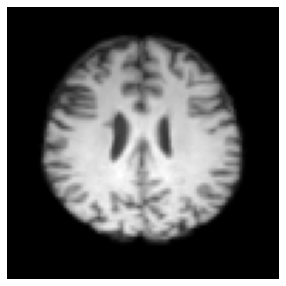

In [5]:
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).long();
train_lab = torch.nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
valid_lab = torch.nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();

# Define transforms
train_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
    RandBiasField(),
    RandGaussianNoise(), 
    EnsureType(data_type='tensor')]);

val_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
    EnsureType(data_type='tensor')]);

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=2, pin_memory=pin_memory);

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,0,:,:,52].T, cmap="gray", origin="lower"); plt.axis('off');

In [6]:
# create a training data loader
train_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=train_batch, shuffle=True, num_workers=5, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=valid_list, labels=valid_lab[0,:,:], transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=val_batch, num_workers=5, pin_memory=pin_memory)

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

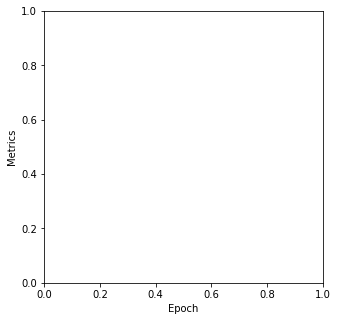

In [8]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
#model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)
# model = monai.networks.nets.UNETR(spatial_dims=3, in_channels=1, out_channels=2, img_size=im_size).to(device)
model = monai.networks.nets.ViT(spatial_dims=3, in_channels=1, img_size=im_size, patch_size=pat_size, classification=True).to(device)
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )

# model = ViT(
#     dim=128,
#     image_size=96,
#     patch_size=32,
#     num_classes=2,
#     transformer=efficient_transformer,
#     channels=1,
# ).to(device)

# loss_function
#loss_function = torch.nn.BCELoss() 
#loss_function = torch.nn.BCEWithLogitsLoss() 
#loss_function = torch.nn.SoftMarginLoss()  
#loss_function = torch.nn.HingeEmbeddingLoss()
#loss_function = torch.nn.HuberLoss()
loss_function = torch.nn.CrossEntropyLoss() 

lr = 1e-4
wd = 1e-5
auc = []
best_acc = -1

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
writer = SummaryWriter()
max_epochs = 2

# wb.init(project="ACT-CNN",
#            config={
#                "batch_size": train_batch,
#                "learning_rate": lr,
#                "dataset": "ACT",
#            })

# Plotting
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')
plt.ion()
fig.show()
fig.canvas.draw()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd, amsgrad=True)
# auc_metric = monai.metrics.ROCAUCMetric()

for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);

        output = model(inputs)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(epoch_acc)
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
        #wb.log({'loss': loss, 'acc': acc})

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            
            val_output = model(images)
            val_loss = criterion(val_output, val_labels)

            val_acc = (val_output.argmax(dim=1) == val_labels).float().mean()
            epoch_val_accuracy += val_acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
        
ax.clear()
train_epochs = np.linspace(1, max_epochs, max_epochs)
ax.plot(train_epochs, epoch_loss_values, label='loss')
ax.plot(train_epochs, epoch_acc_values, label='ACC')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')
ax.legend()
fig.canvas.draw()
# wb.finish()

In [ ]:
# create a validation data loader
print('Test Set: ',labels[339:].shape); test_batch=5
test_ds = ImageDataset(image_files=images[339:], labels=labels[339:], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=test_batch, num_workers=5, pin_memory=pin_memory)

with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(
            device), test_data[1].to(device),

        outputs = model(test_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, test_labels], dim=0)     

print(classification_report(
    (y.cpu().numpy() == 1).nonzero()[2],
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    (y.cpu().numpy() == 1).nonzero()[2],
    y_pred.cpu().numpy(),
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Occulusion Sensitivity

In [ ]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[314:], labels=labels[314:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)

def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [ ]:
# Get a random image and its corresponding label
img, label = get_next_im()

In [ ]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2;
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box);
occ_result = occ_result[..., label.argmax().item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)